## A Nighttime Light (NTL) Analysis of the Turkish Economy

This Jupyter notebook contains the source code used for my study (more details at https://youtu.be/CCL3_KghIaM) of the correlation between GDP and nighttime light in Turkey, and an explanation of how you can run it locally. 

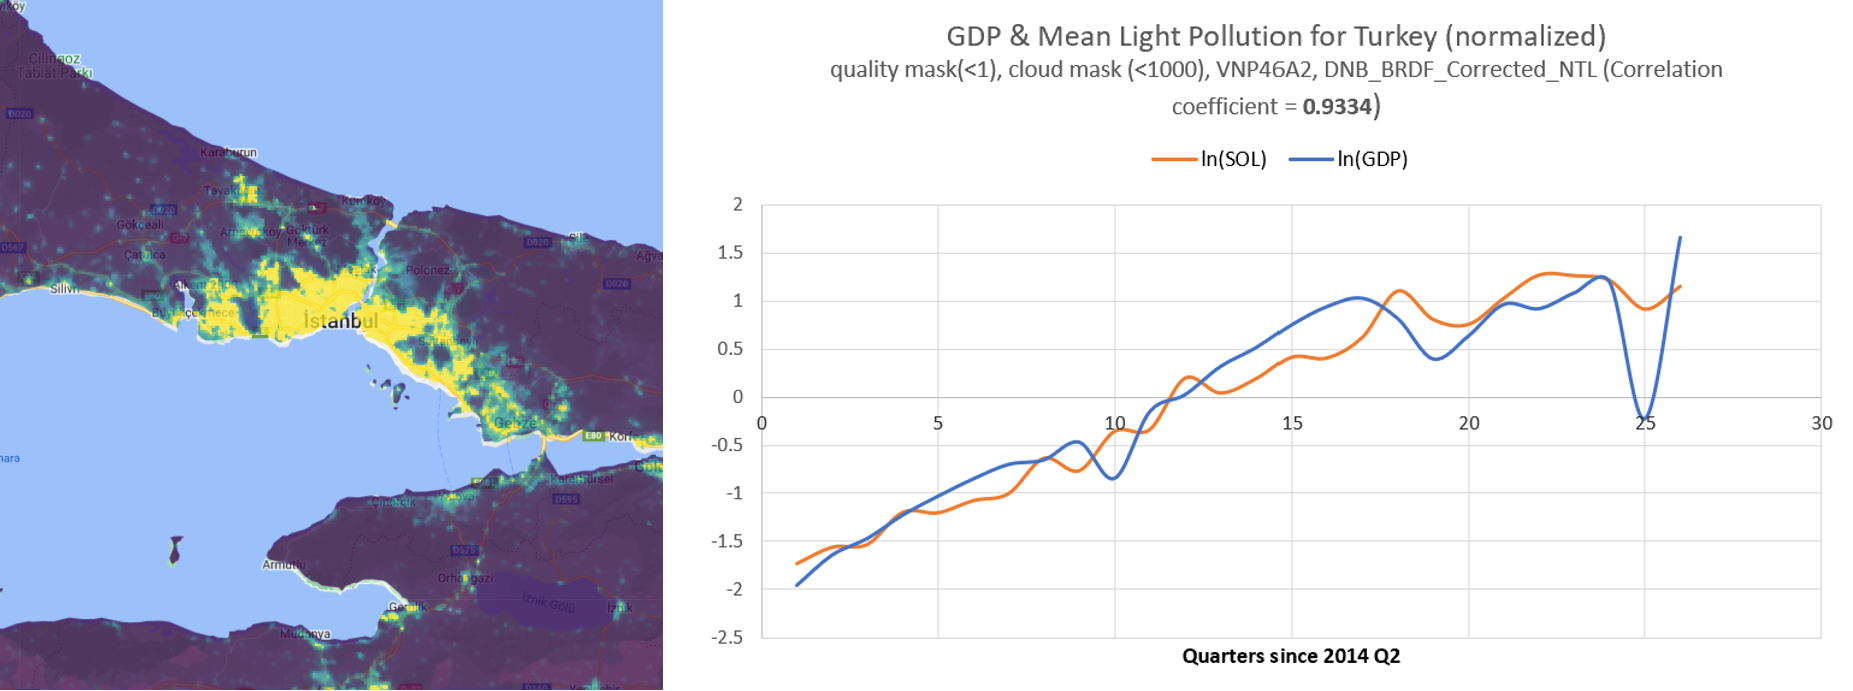

When running this code for the first time, you will be prompted to provide a code to authenticate Google Earth Engine. Follow the instructions provided by the link which pops up. 

In [1]:
import geemap
import ee

# Initialize Google Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To clean the data, we will have to create a custom mask out of the 2015 & 2016 EOG annual composites. Start by downloading 

In [3]:
# Imports annual composites for Europe & Asia
import geemap, ee
ee.Initialize()
vcm_orm_ntl_2015_asia = ee.Image.loadGeoTIFF("gs://2015_composite_asia/SVDNB_npp_20150101-20151231_75N060E_vcm-orm-ntl_v10_c201701311200.avg_rade9-COG.tif")
vcm_orm_ntl_2016_asia = ee.Image.loadGeoTIFF("gs://2016_composite_asia/SVDNB_npp_20160101-20161231_75N060E_vcm-orm-ntl_v10_c201807311200.avg_rade9-COG.tif")
vcm_orm_ntl_2015_europe = ee.Image.loadGeoTIFF("gs://2015_composite_europe/SVDNB_npp_20150101-20151231_75N060W_vcm-orm-ntl_v10_c201701311200.avg_rade9-COG.tif")
vcm_orm_ntl_2016_europe = ee.Image.loadGeoTIFF("gs://2016_composite_europe/SVDNB_npp_20160101-20161231_75N060W_vcm-orm-ntl_v10_c201807311200.avg_rade9-COG.tif")

continent_collection_2015 = ee.ImageCollection([vcm_orm_ntl_2015_asia, vcm_orm_ntl_2015_europe])
continent_collection_2016 = ee.ImageCollection([vcm_orm_ntl_2016_asia, vcm_orm_ntl_2016_europe])

mosaic_2015 = continent_collection_2015.mosaic()
mosaic_2016 = continent_collection_2016.mosaic()

eog_mask = mosaic_2015.add(mosaic_2016)
eog_mask = eog_mask.mask(eog_mask)

In [4]:
# Controls color scheme
vis_params = {
    'min':0,
    'max':60,
  'palette': ['380245', '23678b', '21908c', '39b185', 'fde725'],
  'opacity': 0.75
}

Below, we can visually compare the difference in NTL data reported by the DMSP and VIIRS satellites. Notice how the VIIRS data (right-hand side) avoids the 'bleaching' effect apparent in the DMSP data (left-hand side) as you zoom into the city-level.

In [5]:
turkey = ee.FeatureCollection("FAO/GAUL/2015/level0") \
            .filter(ee.Filter.eq('ADM0_NAME', 'Turkey'))

# DATE RANGE: 2014-01-01 - 2023-02-01
viirs_quarterly = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
                    .filterDate("2014-01-01","2014-12-31") \
                    .select('avg_rad') \
                    .median() \

# Imports DMSP 2013 annual composite
dmsp13 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F182013").select('stable_lights')

viirs_quarterly_tile = geemap.ee_tile_layer(viirs_quarterly.clip(turkey), vis_params, "VIIRS 2014 composite")
dmsp13_tile = geemap.ee_tile_layer(dmsp13.clip(turkey), vis_params, name="DMSP 2013 composite")

#viirs_quarterly_clean = viirs_quarterly.mask(eog_mask)

lat=38.9
lon=35
map3 = geemap.Map(center=[lat,lon],zoom=6)
map3.split_map(left_layer = dmsp13_tile, right_layer = viirs_quarterly_tile)
#map3.addLayer(dmsp13.clip(turkey), vis_params, name="DMSP Quarterly")
#map3.addLayer(viirs_quarterly.mask(eog_mask), vis_params, "VIIRS Quarterly")
#map3.addLayer(viirs_quarterly_clean.clip(turkey), vis_params, "VIIRS Quarterly Clean")

map3.addLayerControl()
map3

Map(center=[38.9, 35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…